In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline, set_seed, GPT2Tokenizer, TFGPT2Model
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import MinMaxScaler

In [98]:
df = pd.read_csv('web_scrapping/attraction_info_df_final_1.csv')
df.head()

,No,location_id,location_type,ratings,no. of rating,provience,cost,user_id,best time to visit,visiting_hours,Address,Website_link,image_link
0,0,Ripleys Aquarium of Canada,Aquariums,4.5,"20,326",ontario,15$,1,summer,Sun - Sat 10:00 AM - 8:00 PM,"288 Bremner Boulevard, Toronto, Ontario M5V 3L...",http://www.ripleyaquariums.com/canada,https://dynamic-media-cdn.tripadvisor.com/medi...
1,1,Mount Royal Park,Parks,4.5,"10,493",quebec,5$,2,fall,Sun - Sat 6:00 AM - 12:00 AM,"1260 Remembrance Road, Montreal, Quebec H3H 1A...",http://www.lemontroyal.qc.ca/en,https://dynamic-media-cdn.tripadvisor.com/medi...
2,2,Stanley Park,Parks,4.5,"28,722",BC,free,3,all time,Sun-Sat 8:00 AM- 6:00 PM,"Stanley Park Causeway, Vancouver, British Colu...",http://vancouver.ca/parks-recreation-culture/s...,https://dynamic-media-cdn.tripadvisor.com/medi...
3,3,Niagara Falls Canada,Points of Interest and Landmarks Waterfalls,5.0,"31,477",ontario,free,4,all time,Thu - Thu 12:00 AM - 11:59 PM,"Niagara Falls, Ontario L2G 3Y9 Canada",https://www.niagarafallstourism.com/,https://dynamic-media-cdn.tripadvisor.com/medi...
4,4,Old Quebec,Neighbourhoods Historic Walking Areas,5.0,"13,360",quebec,10$,5,summer,Sun - Sat 10:00 AM - 8:00 PM,"Rue de Tresor, Quebec City, Quebec GIR 5B8 Canada",http://whc.unesco.org/en/list/300,https://dynamic-media-cdn.tripadvisor.com/medi...


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   No                  60 non-null     int64  
 1   location_id         60 non-null     object 
 2   location_type       60 non-null     object 
 3   ratings             60 non-null     float64
 4   no. of rating       60 non-null     object 
 5   provience           60 non-null     object 
 6   cost                60 non-null     object 
 7   user_id             60 non-null     int64  
 8   best time to visit  60 non-null     object 
 9   visiting_hours      60 non-null     object 
 10  Address             60 non-null     object 
 11  Website_link        60 non-null     object 
 12  image_link          60 non-null     object 
dtypes: float64(1), int64(2), object(10)
memory usage: 6.2+ KB


In [100]:
# Dropping a column
df.drop(['No','cost','user_id','Website_link','image_link'], axis=1, inplace=True)
# Filling missing values
df['ratings'].fillna('0', inplace=True)

In [101]:
df.head()

,location_id,location_type,ratings,no. of rating,provience,best time to visit,visiting_hours,Address
0,Ripleys Aquarium of Canada,Aquariums,4.5,"20,326",ontario,summer,Sun - Sat 10:00 AM - 8:00 PM,"288 Bremner Boulevard, Toronto, Ontario M5V 3L..."
1,Mount Royal Park,Parks,4.5,"10,493",quebec,fall,Sun - Sat 6:00 AM - 12:00 AM,"1260 Remembrance Road, Montreal, Quebec H3H 1A..."
2,Stanley Park,Parks,4.5,"28,722",BC,all time,Sun-Sat 8:00 AM- 6:00 PM,"Stanley Park Causeway, Vancouver, British Colu..."
3,Niagara Falls Canada,Points of Interest and Landmarks Waterfalls,5.0,"31,477",ontario,all time,Thu - Thu 12:00 AM - 11:59 PM,"Niagara Falls, Ontario L2G 3Y9 Canada"
4,Old Quebec,Neighbourhoods Historic Walking Areas,5.0,"13,360",quebec,summer,Sun - Sat 10:00 AM - 8:00 PM,"Rue de Tresor, Quebec City, Quebec GIR 5B8 Canada"


In [102]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
label_encoder = LabelEncoder()

# List of columns to encode
columns_to_encode = ['location_id', 'location_type', 'provience', 'best time to visit', 'visiting_hours','Address']

# Apply LabelEncoder to each column in the list
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])

In [103]:
df.head()

,location_id,location_type,ratings,no. of rating,provience,best time to visit,visiting_hours,Address
0,57,0,4.5,"20,326",9,2,11,14
1,53,26,4.5,"10,493",10,1,14,7
2,59,26,4.5,"28,722",0,0,16,53
3,54,31,5.0,"31,477",9,0,17,42
4,55,25,5.0,"13,360",10,2,11,50


In [104]:
from sklearn.ensemble import RandomForestClassifier
df['no. of rating'] = df['no. of rating'].str.replace(',', '').astype(float)

# Assuming 'target' is your categorical target variable and it's already encoded
X = df.drop('location_id', axis=1)
y = df['location_id']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Getting feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)



no. of rating         0.197835
Address               0.196471
location_type         0.191998
visiting_hours        0.155388
provience             0.116536
best time to visit    0.085068
ratings               0.056705
dtype: float64


In [105]:
correlation_matrix = df.corr()
# Assuming 'target' is your target variable
target_correlation = correlation_matrix['location_id'].sort_values(ascending=False)
print(target_correlation)


location_id           1.000000
no. of rating         0.341151
location_type         0.060755
visiting_hours        0.035441
provience             0.015166
best time to visit   -0.004062
ratings              -0.060871
Address              -0.072965
Name: location_id, dtype: float64


In [106]:
# Now let's normalize 'no. of rating' column
scaler = MinMaxScaler()
df['no. of rating'] = scaler.fit_transform(df[['no. of rating']])
df.head()

,location_id,location_type,ratings,no. of rating,provience,best time to visit,visiting_hours,Address
0,57,0,4.5,0.645505,9,2,11,14
1,53,26,4.5,0.332909,10,1,14,7
2,59,26,4.5,0.912417,0,0,16,53
3,54,31,5.0,1.000000,9,0,17,42
4,55,25,5.0,0.424053,10,2,11,50


In [108]:
X = df.drop('location_id', axis=1)
y = df['location_id']
# Assuming 'X' is your feature matrix and 'y' is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.values.reshape((X_train.shape[0], X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1]))

In [109]:
import tensorflow as tf
from transformers import TFGPT2Model, GPT2Config

# Load pretrained model
pretrained_gpt2 = TFGPT2Model.from_pretrained('gpt2')

# Define your custom model
class CustomGPT2(tf.keras.Model):
    def __init__(self):
        super(CustomGPT2, self).__init__()
        self.gpt2 = pretrained_gpt2
        self.lstm = tf.keras.layers.LSTM(pretrained_gpt2.config.n_embd, return_sequences=True)
        self.new_layer = tf.keras.layers.Dense(1)

    def call(self, inputs):
        gpt2_output = self.gpt2(inputs)[0]
        lstm_output = self.lstm(gpt2_output)
        output = self.new_layer(lstm_output[:, -1, :])  # Use the last LSTM output
        return output

# Initialize your custom model
model = CustomGPT2()

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [110]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# Compile model
model.compile(optimizer='adam',loss='mean_squared_error')
# Train lstm model
history_lstm = model.fit(X_train, y_train, epochs=100, batch_size=32, 
          validation_data=(X_train, y_train), callbacks=[early_stopping])
model.summary() # Print model structure

Epoch 1/100
2/2 [==============================] - 28s 6s/step - loss: 1092.2296 - val_loss: 883.2310
Epoch 2/100
2/2 [==============================] - 5s 3s/step - loss: 817.6705 - val_loss: 1070.7583
Epoch 3/100
2/2 [==============================] - 6s 3s/step - loss: 1025.9017 - val_loss: 782.4525
Epoch 4/100
2/2 [==============================] - 6s 3s/step - loss: 663.1101 - val_loss: 389.7738
Epoch 5/100
2/2 [==============================] - 6s 3s/step - loss: 384.5265 - val_loss: 323.3546
Epoch 6/100
2/2 [==============================] - 7s 4s/step - loss: 369.1239 - val_loss: 295.9944
Epoch 7/100
2/2 [==============================] - 7s 3s/step - loss: 297.6678 - val_loss: 292.7089
Epoch 8/100
2/2 [==============================] - 6s 3s/step - loss: 293.9524 - val_loss: 294.6873
Epoch 9/100
2/2 [==============================] - 6s 3s/step - loss: 299.8242 - val_loss: 297.5106
Epoch 10/100
2/2 [==============================] - 6s 3s/step - loss: 298.0449 - val_loss: 293.

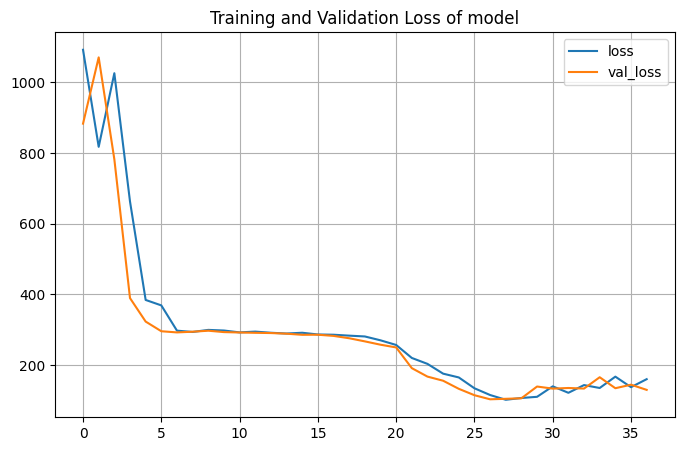

In [111]:
# Draw the loss curve of model
data={}
data['loss']=history_lstm.history['loss']

data['val_loss']=history_lstm.history['val_loss']
pd.DataFrame(data).plot(figsize=(8,5))
plt.grid(True)
plt.title('Training and Validation Loss of model')
plt.legend()
plt.show()

In [115]:
# Save the model
model.save('my_model')

# # Load the model
# from tensorflow.keras.models import load_model
# model = load_model('my_model')

INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


In [119]:
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer
from tensorflow.keras.models import load_model
# Load pre-trained model tokenizer (vocabulary)
tokenizer = load_model('my_model/saved_model.pb')

# Load pre-trained model (weights)
model = load_model('my_model/saved_model.pb')

# Encode input context
input_context = "I am planning to visit Toronto for a 3-day trip on 2/2/2024. Can you suggest a plan?"
input_ids = tokenizer.encode(input_context, return_tensors='tf')

# Generate text until the output length (which includes the context length) reaches 50
output = model.generate(input_ids, max_length=500, num_return_sequences=5, no_repeat_ngram_size=2, 
                        do_sample=True, temperature=0.7)

# Decode the output
for i in range(5):
    print(f"Generated plan {i+1}: {tokenizer.decode(output[i], skip_special_tokens=True)}")

OSError: Unable to synchronously open file (file signature not found)